# Sustainability Analyst: A 48-Hour Sprint in Uncovering Insights

By Samuel Alter

## Notebook Overview

This notebook's goal is to analyze global coal mining emissions data. There is a lot of data to unpack; I encourage the reader to scroll through this notebook for an in-depth analysis. That being said, these are the three datasets from the set:
* Emissions by country
  * Lists emissions by country
* Emission sources
  * Lists individual coal mines' emissions
* Ownership
  * Data on the parent companies of the coal mines
  
Methane ($CH_4$) and Carbon Dioxide ($CO_2$) is included in the datasets and will be the focus of this notebook. Many figures were created in service of understanding the relationships between the datasets.

The data was sourced from the [Climate TRACE](#https://climatetrace.org/data) website. Climate TRACE is an organization that uses independently-verified data, sourced and derived from advanced technologies like satellite imagery, enhanced with machine learning tools. Climate TRACE's values are closely aligned to those who care about sustainability; the work described here will show the promise of using Climate TRACE’s data to help people make informed investment decisions if they're interested in investing in sustainability.

## Imports

In [438]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import duckdb
import geopandas as gpd
import warnings

## Figures

### `country_emissions` table

In [439]:
# import data
country_emissions=pd.read_csv('../_data/coal-mining_country_emissions.csv')

In [440]:
country_emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   iso3_country              10000 non-null  object 
 1   sector                    10000 non-null  object 
 2   subsector                 10000 non-null  object 
 3   start_time                10000 non-null  object 
 4   end_time                  10000 non-null  object 
 5   gas                       10000 non-null  object 
 6   emissions_quantity        10000 non-null  float64
 7   emissions_quantity_units  10000 non-null  object 
 8   temporal_granularity      10000 non-null  object 
 9   created_date              10000 non-null  object 
 10  modified_date             0 non-null      float64
dtypes: float64(2), object(9)
memory usage: 859.5+ KB


In [441]:
country_emissions.sample(5)

,iso3_country,sector,subsector,start_time,end_time,gas,emissions_quantity,emissions_quantity_units,temporal_granularity,created_date,modified_date
7387,PSE,fossil-fuel-operations,coal-mining,2020-01-01 00:00:00,2020-12-31 00:00:00,co2e_100yr,0.000000,tonnes,annual,2023-10-03 21:10:36.696955,NaN
7359,PRY,fossil-fuel-operations,coal-mining,2022-01-01 00:00:00,2022-12-31 00:00:00,n2o,0.000000,tonnes,annual,2023-10-03 21:10:37.097933,NaN
2877,ETH,fossil-fuel-operations,coal-mining,2022-01-01 00:00:00,2022-12-31 00:00:00,co2e_100yr,312807.590288,tonnes,annual,2023-10-03 21:10:37.009276,NaN
3046,FRO,fossil-fuel-operations,coal-mining,2016-01-01 00:00:00,2016-12-31 00:00:00,co2,0.000000,tonnes,annual,2023-10-03 21:10:36.047429,NaN
5355,LUX,fossil-fuel-operations,coal-mining,2022-01-01 00:00:00,2022-12-31 00:00:00,ch4,0.000000,tonnes,annual,2023-10-03 21:10:37.05601,NaN


In [442]:
# add full country name to table to make it more readable
iso3=pd.read_csv('../_data/iso3_country.csv')
iso3=iso3[['country_name','alpha_3_code']]
iso3

,country_name,alpha_3_code
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,American Samoa,ASM
4,Andorra,AND
...,...,...
244,Western Sahara,ESH
245,Yemen,YEM
246,Zambia,ZMB
247,Zimbabwe,ZWE


We have to see if all the countries are represented in the data:

In [443]:
ce_set=set(country_emissions['iso3_country'])
iso3_set=set(iso3['alpha_3_code'])

missing_in_iso3=ce_set-iso3_set
missing_in_ce=iso3_set-ce_set

print('missing_in_ce:',missing_in_ce)
print('missing_in_iso3',missing_in_iso3)

missing_in_ce: set()
missing_in_iso3 {'XKX'}


We'll need to add Kosovo to the `iso3` dataframe:

In [444]:
if 'XKX' not in iso3['alpha_3_code'].values:
    kosovo_row={'country_name':'Kosovo','alpha_3_code':'XKX'}
    kosovo_row_df=pd.DataFrame([kosovo_row])
    iso3=pd.concat([iso3,kosovo_row_df],ignore_index=True)
    if 'XKX' in iso3['alpha_3_code'].values:
        print('Kosovo successfully added')
        print(iso3)
    else:
        print('error!')

Kosovo successfully added
       country_name alpha_3_code
0       Afghanistan          AFG
1           Albania          ALB
2           Algeria          DZA
3    American Samoa          ASM
4           Andorra          AND
..              ...          ...
245           Yemen          YEM
246          Zambia          ZMB
247        Zimbabwe          ZWE
248   Åland Islands          ALA
249          Kosovo          XKX

[250 rows x 2 columns]


In [445]:
if 'country_name' not in country_emissions.columns:
    
    country_emissions=pd.merge(country_emissions,
                               iso3,
                               left_on='iso3_country',
                               right_on='alpha_3_code',
                               how='inner')
    
print('country_name' in country_emissions.columns)

True


Are `start_time` and `end_time` always the first and last day of the year, respectively?

In [447]:
country_emissions['start_time'].value_counts()

2015-01-01 00:00:00    1250
2016-01-01 00:00:00    1250
2017-01-01 00:00:00    1250
2018-01-01 00:00:00    1250
2019-01-01 00:00:00    1250
2020-01-01 00:00:00    1250
2021-01-01 00:00:00    1250
2022-01-01 00:00:00    1250
Name: start_time, dtype: int64

In [448]:
country_emissions['end_time'].value_counts()

2015-12-31 00:00:00    1250
2016-12-31 00:00:00    1250
2017-12-31 00:00:00    1250
2018-12-31 00:00:00    1250
2019-12-31 00:00:00    1250
2020-12-31 00:00:00    1250
2021-12-31 00:00:00    1250
2022-12-31 00:00:00    1250
Name: end_time, dtype: int64

They are. Let's make a new column with just the year.

In [449]:
country_emissions['start_time']=pd.to_datetime(country_emissions['start_time'])

# check to see if it changed
# country_emissions.info()
# yes

In [450]:
import datetime as dt

In [451]:
# create a column for just the year
country_emissions['year']=country_emissions['start_time'].dt.year
country_emissions['year'].value_counts()

2015    1250
2016    1250
2017    1250
2018    1250
2019    1250
2020    1250
2021    1250
2022    1250
Name: year, dtype: int64

In [452]:
def nUnique(df,sample=False):
    '''
    Create a dataframe that summarizes how many unique values are in each column of the dataframe.
    If sample=True, returns a sampled row from the original dataframe within the summary dataframe.
    '''
    
    column_names=[col for col in df.columns]
    n_unique_values=[df[col].nunique() for col in df.columns]

    data={'column_name':column_names,'n_unique_values':n_unique_values}

    df_nunique=pd.DataFrame(data)
    
    if sample:
        sample_row=df.sample(n=1)
        sample_row=sample_row.T.reset_index()
        sample_row.columns=['column_name','sampled_value']
        
        df_nunique=df_nunique.merge(sample_row,on='column_name',how='left')
        
    return df_nunique

In [453]:
# investigate the number of unique values in each column
nUnique(country_emissions)

,column_name,n_unique_values
0,iso3_country,250
1,sector,1
2,subsector,1
3,start_time,8
4,end_time,8
5,gas,5
6,emissions_quantity,379
7,emissions_quantity_units,1
8,temporal_granularity,1
9,created_date,10000


We're really working with eight years' of data, consisting of 250 countries, and five gas categories.

In [454]:
# functions to compute the quantiles
def q25(x):
    return x.quantile(0.25)

def q50(x):
    return x.quantile(0.50)

def q75(x):
    return x.quantile(0.75)

def iqr(x):
    return q75(x)-q25(x)

groupby_list=['count','mean','std','min',q25,q50,q75,iqr]

country_emissions_describe=country_emissions.\
groupby(['gas']).\
agg({'emissions_quantity':groupby_list}).\
round(decimals=2) # to help with visual table size

country_emissions_describe

emissions_quantity                                            \
                        count         mean           std  min  q25  q50   
gas                                                                       
ch4                      2000    187182.19  2.049240e+06  0.0  0.0  0.0   
co2                      2000         0.00  0.000000e+00  0.0  0.0  0.0   
co2e_100yr               2000   5241101.20  5.737873e+07  0.0  0.0  0.0   
co2e_20yr                2000  15723303.61  1.721362e+08  0.0  0.0  0.0   
n2o                      2000         0.00  0.000000e+00  0.0  0.0  0.0   

                                
                 q75       iqr  
gas                             
ch4           153.74    153.74  
co2             0.00      0.00  
co2e_100yr   4304.84   4304.84  
co2e_20yr   12914.51  12914.51  
n2o             0.00      0.00

There is no data for CO2 and N2O.

#### Barplot of Emissions Per Year

In [455]:
gas_year=country_emissions.groupby(['year','gas']).agg({'emissions_quantity':'sum'}).reset_index()
# note: no data for co2, n2o
gas_year= gas_year[(gas_year['gas'] != 'co2') & (gas_year['gas'] != 'n2o')]
gas_year['sum_emissions']=gas_year['emissions_quantity'].apply(lambda x: '{:.0f}'.format(x)).astype(int)
gas_year

,year,gas,emissions_quantity,sum_emissions
0,2015,ch4,4.224394e+07,42243937
2,2015,co2e_100yr,1.182830e+09,1182830232
3,2015,co2e_20yr,3.548491e+09,3548490695
5,2016,ch4,4.241621e+07,42416206
7,2016,co2e_100yr,1.187654e+09,1187653763
8,2016,co2e_20yr,3.562961e+09,3562961290
10,2017,ch4,4.513359e+07,45133595
12,2017,co2e_100yr,1.263741e+09,1263740648
13,2017,co2e_20yr,3.791222e+09,3791221943
15,2018,ch4,4.657575e+07,46575752


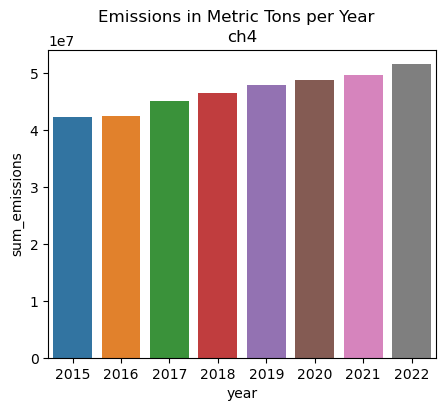

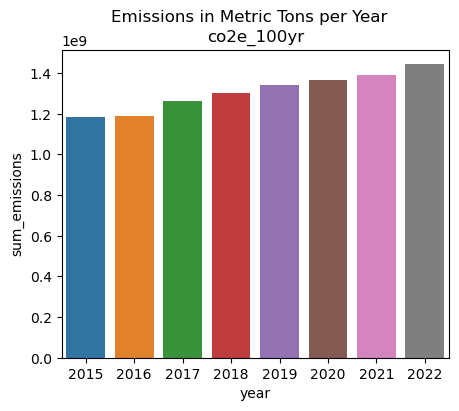

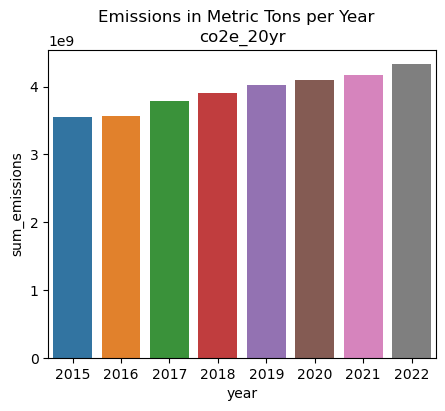

In [456]:
gases=list(gas_year['gas'].unique())
titles=gases # titles is using gases too
file_names=['due20240829_'+item for item in gases]

for gas,title,file_name in zip(gases,titles,file_names):
    plt.figure(figsize=(5,4))
    sns.barplot(data=gas_year[gas_year['gas']==gas],
                x='year',
                y='sum_emissions')
    plt.title(title)
    plt.suptitle('Emissions in Metric Tons per Year')
    
    plt.savefig(f'../_figs/{file_name}.pdf')
    plt.savefig(f'../_figs/{file_name}.png')
                
    plt.show()
    

The emissions increase over time. It's curious that the pattern is the same for all the plots.

In [458]:
con=duckdb.connect(database=':memory:')
con.register('country_emissions',country_emissions)
country_sum=con.execute('''
select
    country_name
    ,gas
    ,sum(emissions_quantity) as sum_emissions
from country_emissions
where gas='ch4'
group by country_name,gas;
''').fetchdf()
con.close()
country_sum

,country_name,gas,sum_emissions
0,Brazil,ch4,4.354024e+04
1,Brunei Darussalam,ch4,0.000000e+00
2,Chile,ch4,0.000000e+00
3,China,ch4,2.560940e+08
4,Congo (the Democratic Republic of the),ch4,0.000000e+00
...,...,...,...
245,Sierra Leone,ch4,0.000000e+00
246,Seychelles,ch4,0.000000e+00
247,Syrian Arab Republic,ch4,0.000000e+00
248,Trinidad and Tobago,ch4,0.000000e+00


In [459]:
country_sum['sum_emissions']=country_sum['sum_emissions'].apply(lambda x: '{:.0f}'.format(x)).astype(int)
country_sum

,country_name,gas,sum_emissions
0,Brazil,ch4,43540
1,Brunei Darussalam,ch4,0
2,Chile,ch4,0
3,China,ch4,256093993
4,Congo (the Democratic Republic of the),ch4,0
...,...,...,...
245,Sierra Leone,ch4,0
246,Seychelles,ch4,0
247,Syrian Arab Republic,ch4,0
248,Trinidad and Tobago,ch4,0


It looks like there are a lot of countries with zero emissions. Let's just view the countries _with_ emissions:

In [460]:
country_sum_nonz=country_sum[country_sum['sum_emissions']!=0].sort_values(by='sum_emissions',ascending=False)
country_sum_nonz_top10=country_sum_nonz.head(10)
country_sum_nonz_top10

,country_name,gas,sum_emissions
3,China,ch4,256093993
145,United States of America (the),ch4,23881545
30,Australia,ch4,21850157
207,Russian Federation (the),ch4,17005708
72,India,ch4,8942060
187,South Africa,ch4,8779092
169,Indonesia,ch4,7533086
112,Poland,ch4,7021240
12,Kazakhstan,ch4,3375596
144,Ukraine,ch4,3161952


#### Barplot of the Top 10 Most-Emitting Countries

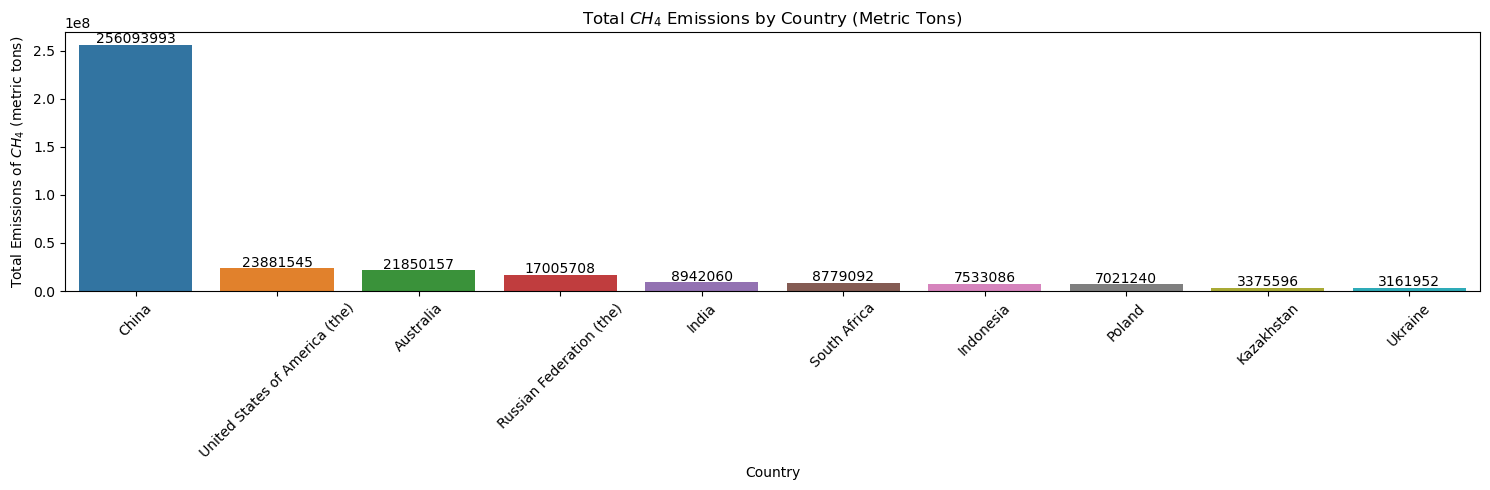

In [461]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(data=country_sum_nonz_top10, x='country_name', y='sum_emissions')

plt.title('Total $CH_4$ Emissions by Country (Metric Tons)')
plt.xlabel('Country')
plt.ylabel('Total Emissions of $CH_4$ (metric tons)')
plt.xticks(rotation=45)
plt.tight_layout()

for bar in ax.patches:
    height=bar.get_height()
    ax.annotate(format(height, '.0f'),
                     (bar.get_x() + bar.get_width() / 2., height),
                     ha = 'center', va = 'center',
                     xytext = (0, 4),
                     textcoords = 'offset points')

plt.savefig('../_figs/due20240829_total_country_emissions.pdf')
plt.savefig('../_figs/due20240829_total_country_emissions.png')

# Show the plot
plt.show()

China, USA, Australia, and Russia lead the world in emissions.

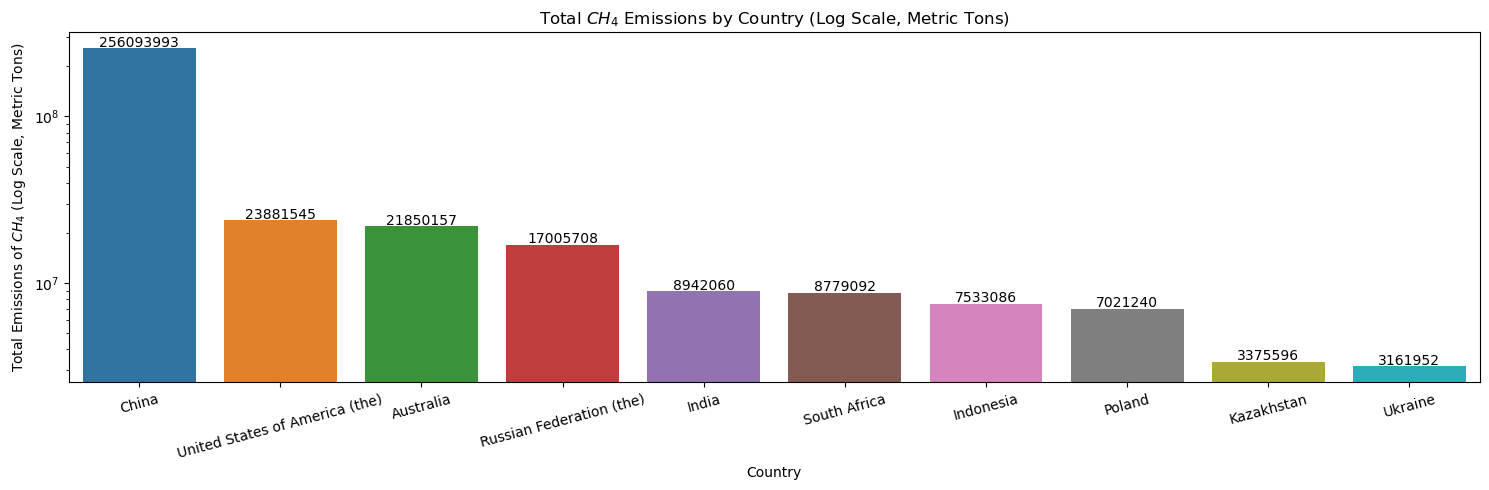

In [546]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data=country_sum_nonz_top10, x='country_name', y='sum_emissions')

plt.title('Total $CH_4$ Emissions by Country (Log Scale, Metric Tons)')
plt.xlabel('Country')
plt.ylabel('Total Emissions of $CH_4$ (Log Scale, Metric Tons)')
plt.xticks(rotation=15)
plt.yscale('log')
plt.tight_layout()

for bar in ax.patches:
    height=bar.get_height()
    ax.annotate(format(height, '.0f'),
                     (bar.get_x() + bar.get_width() / 2., height),
                     ha = 'center', va = 'center',
                     xytext = (0, 4),
                     textcoords = 'offset points')
    
plt.savefig('../_figs/due20240829_total_country_emission_sources_log.pdf')
plt.savefig('../_figs/due20240829_total_country_emission_sources_log.png')

# Show the plot
plt.show()

In [463]:
nUnique(country_emissions)

,column_name,n_unique_values
0,iso3_country,250
1,sector,1
2,subsector,1
3,start_time,8
4,end_time,8
5,gas,5
6,emissions_quantity,379
7,emissions_quantity_units,1
8,temporal_granularity,1
9,created_date,10000


In [464]:
# Not informative
# 
# 
# # Compute Cramér's V matrix
# cv_matrix = cramers_v_matrix(country_emissions)

# # generate mask for the upper triangle
# mask = np.triu(np.ones_like(cv_matrix, dtype=bool))

# # Plot the correlation matrix
# plt.figure(figsize=(12, 10))
# sns.heatmap(cv_matrix, annot=True, cmap='coolwarm', #vmin=-1, vmax=1,
#             mask=mask, cbar_kws={"shrink": .8},fmt='.2f')

# plt.title("Cramér's V Correlation Matrix")

# # save fig
# # plt.savefig('../_figs/due20240829_country_emissions_categorical_correlation.pdf')
# # plt.savefig('../_figs/due20240829_country_emissions_categorical_correlation.png')

# plt.show()

In [465]:
# Not informative
# 
# 
# # compute correlation matrix
# corr=country_emissions.corr()

# # generate mask for the upper triangle
# mask=np.triu(np.ones_like(corr, dtype=bool))

# # set up matplotlib figure
# f,ax = plt.subplots(figsize=(5, 4))

# # draw heatmap with the mask and correct aspect ratio
# sns.heatmap(corr,mask=mask,cmap='coolwarm',#vmax=1,vmin=-1,
#             center=0,
#             square=True,linewidths=.5,annot=True,
#             fmt='.2f',cbar_kws={"shrink":.5})
# plt.title('Correlation Matrix of Numerical Features\n$Higher$ $absolute$ $value$ $indicates$ $stronger$ $correlation$')
# plt.tight_layout()

# # save fig
# # plt.savefig('../_figs/due20240829_country_emissions_categorical_correlation.pdf')
# # plt.savefig('../_figs/due20240829_country_emissions_categorical_correlation.pdf')

### `emissions_sources` table

In [466]:
emissions_sources=pd.read_csv('../_data/coal-mining_emissions_sources.csv')

In [467]:
emissions_sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119505 entries, 0 to 119504
Data columns (total 43 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   source_id               119505 non-null  int64  
 1   source_name             119505 non-null  object 
 2   source_type             119505 non-null  object 
 3   iso3_country            119505 non-null  object 
 4   sector                  119505 non-null  object 
 5   subsector               119505 non-null  object 
 6   start_time              119505 non-null  object 
 7   end_time                119505 non-null  object 
 8   lat                     119505 non-null  float64
 9   lon                     119505 non-null  float64
 10  geometry_ref            119505 non-null  object 
 11  gas                     119505 non-null  object 
 12  emissions_quantity      95193 non-null   float64
 13  temporal_granularity    119505 non-null  object 
 14  activity            

In [468]:
emissions_sources.sample(3)

,source_id,source_name,source_type,iso3_country,sector,subsector,start_time,end_time,lat,lon,...,other7,other7_def,other8,other8_def,other9,other9_def,other10,other10_def,created_date,modified_date
70863,3163545,Gouri Deep Coal Mine,Surface,IND,fossil-fuel-operations,coal-mining,2017-01-01 00:00:00,2017-12-31 00:00:00,19.774100,79.290200,...,50.0,Mine Depth,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-14 00:00:00,2023-11-03 19:44:15.182195
30078,15464,Qinxin Coal Mine,Underground,CHN,fossil-fuel-operations,coal-mining,2017-01-01 00:00:00,2017-12-31 00:00:00,36.579158,112.182376,...,1115.0,Mine Depth,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-14 00:00:00,2023-11-03 19:44:14.686376
85744,3164274,KWK Sośnica Coal Mine,Underground,POL,fossil-fuel-operations,coal-mining,2017-01-01 00:00:00,2017-12-31 00:00:00,50.274700,18.717100,...,700.0,Mine Depth,NaN,NaN,NaN,NaN,NaN,NaN,2023-09-14 00:00:00,2023-11-03 19:44:15.704649


In [469]:
nUnique(emissions_sources,sample=True)

,column_name,n_unique_values,sampled_value
0,source_id,3164,15304
1,source_name,3161,Jizhong Xin'an Coal Mine
2,source_type,4,Underground
3,iso3_country,68,CHN
4,sector,1,fossil-fuel-operations
5,subsector,1,coal-mining
6,start_time,8,2017-01-01 00:00:00
7,end_time,8,2017-12-31 00:00:00
8,lat,3085,36.340737
9,lon,3086,114.123909


Add year column like with the other tables:

In [470]:
emissions_sources['start_time'].value_counts()

2022-01-01 00:00:00    15820
2021-01-01 00:00:00    15485
2020-01-01 00:00:00    15265
2019-01-01 00:00:00    15025
2018-01-01 00:00:00    14825
2017-01-01 00:00:00    14590
2016-01-01 00:00:00    14360
2015-01-01 00:00:00    14135
Name: start_time, dtype: int64

In [471]:
emissions_sources['end_time'].value_counts()

2022-12-31 00:00:00    15820
2021-12-31 00:00:00    15485
2020-12-31 00:00:00    15265
2019-12-31 00:00:00    15025
2018-12-31 00:00:00    14825
2017-12-31 00:00:00    14590
2016-12-31 00:00:00    14360
2015-12-31 00:00:00    14135
Name: end_time, dtype: int64

In [472]:
emissions_sources['start_time']=pd.to_datetime(emissions_sources['start_time'])

# check to see if it changed
emissions_sources.info()
# yes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119505 entries, 0 to 119504
Data columns (total 43 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   source_id               119505 non-null  int64         
 1   source_name             119505 non-null  object        
 2   source_type             119505 non-null  object        
 3   iso3_country            119505 non-null  object        
 4   sector                  119505 non-null  object        
 5   subsector               119505 non-null  object        
 6   start_time              119505 non-null  datetime64[ns]
 7   end_time                119505 non-null  object        
 8   lat                     119505 non-null  float64       
 9   lon                     119505 non-null  float64       
 10  geometry_ref            119505 non-null  object        
 11  gas                     119505 non-null  object        
 12  emissions_quantity      95193 

In [473]:
# create a column for just the year
emissions_sources['year']=emissions_sources['start_time'].dt.year
emissions_sources['year'].value_counts()

2022    15820
2021    15485
2020    15265
2019    15025
2018    14825
2017    14590
2016    14360
2015    14135
Name: year, dtype: int64

In [474]:
# add full country name like I did with the other tables
if 'country_name' not in emissions_sources.columns:
    
    emissions_sources=pd.merge(emissions_sources,
                               iso3,
                               left_on='iso3_country',
                               right_on='alpha_3_code',
                               how='inner')
    
print('country_name' in emissions_sources.columns)

True


In [475]:
emissions_sources.sample(3)

,source_id,source_name,source_type,iso3_country,sector,subsector,start_time,end_time,lat,lon,...,other8_def,other9,other9_def,other10,other10_def,created_date,modified_date,year,country_name,alpha_3_code
42340,15725,Xintie Coal Mine,Underground,CHN,fossil-fuel-operations,coal-mining,2015-01-01,2015-12-31 00:00:00,45.750588,131.114580,...,NaN,NaN,NaN,NaN,NaN,2023-09-14 00:00:00,2023-11-03 19:44:09.599553,2015,China,CHN
36085,15583,Tashan Coal Mine Baidong Well,Underground,CHN,fossil-fuel-operations,coal-mining,2022-01-01,2022-12-31 00:00:00,39.993508,113.047421,...,NaN,NaN,NaN,NaN,NaN,2023-09-14 00:00:00,2023-11-03 19:44:27.88859,2022,China,CHN
108092,3164868,No. 1 Stripping Mine,Surface,USA,fossil-fuel-operations,coal-mining,2015-01-01,2015-12-31 00:00:00,40.758333,-76.632778,...,NaN,NaN,NaN,NaN,NaN,2023-09-14 00:00:00,2023-11-03 19:44:11.400898,2015,United States of America (the),USA


#### Barplot of the Top 10 Countries with the Most Sources

In [476]:
con=duckdb.connect(database=':memory:')
con.register('emissions_sources',emissions_sources)
result_df=con.execute('''
select 
    count(distinct source_id) as ct
    ,country_name
from emissions_sources
group by country_name
order by ct desc,country_name asc
limit 10;
''').fetchdf()
print(result_df)
con.close()

     ct                    country_name
0  1187                           China
1   493  United States of America (the)
2   420                       Indonesia
3   398                           India
4   151        Russian Federation (the)
5    93                       Australia
6    77                    South Africa
7    37                          Turkey
8    25                          Poland
9    24                        Viet Nam


There are so many sources in China! Let's view this in a barchart:

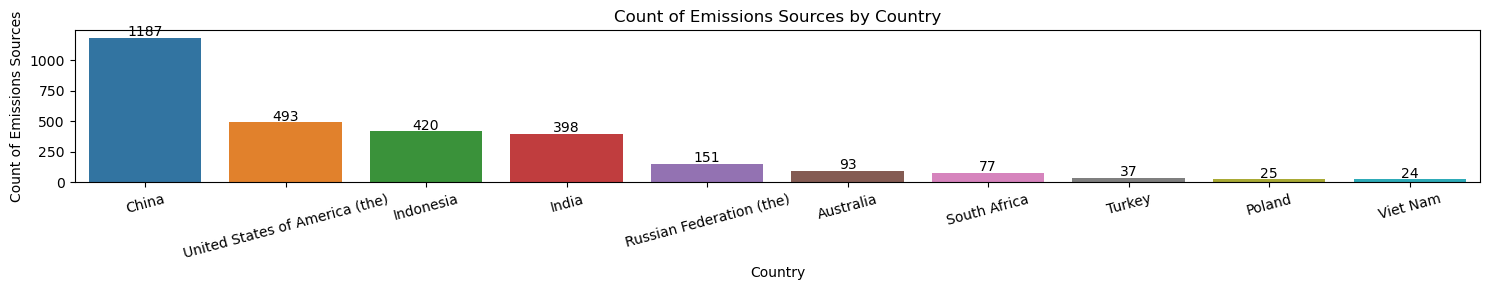

In [477]:
plt.figure(figsize=(15, 3))
ax = sns.barplot(data=result_df, x='country_name', y='ct')

plt.title('Count of Emissions Sources by Country')
plt.xlabel('Country')
plt.ylabel('Count of Emissions Sources')
plt.xticks(rotation=15)
plt.tight_layout()

for bar in ax.patches:
    height=bar.get_height()
    ax.annotate(format(height, '.0f'),
                     (bar.get_x() + bar.get_width() / 2., height),
                     ha = 'center', va = 'center',
                     xytext = (0, 4),
                     textcoords = 'offset points')

plt.savefig('../_figs/due20240829_country_emission_sources.pdf')
plt.savefig('../_figs/due20240829_country_emission_sources.png')

# Show the plot
plt.show()

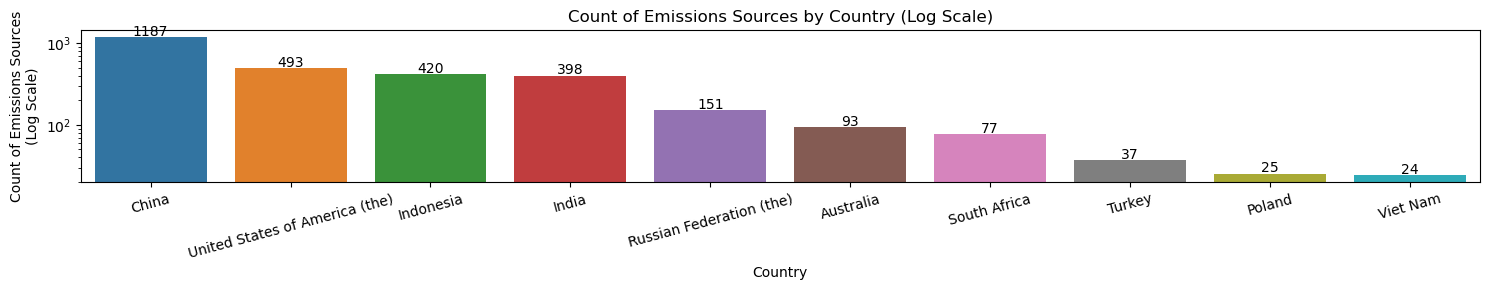

In [478]:
plt.figure(figsize=(15, 3))
ax = sns.barplot(data=result_df, x='country_name', y='ct')

plt.title('Count of Emissions Sources by Country (Log Scale)')
plt.xlabel('Country')
plt.ylabel('Count of Emissions Sources\n(Log Scale)')
plt.xticks(rotation=15)
plt.yscale('log')
plt.tight_layout()

for bar in ax.patches:
    height=bar.get_height()
    ax.annotate(format(height, '.0f'),
                     (bar.get_x() + bar.get_width() / 2., height),
                     ha = 'center', va = 'center',
                     xytext = (0, 4),
                     textcoords = 'offset points')

plt.savefig('../_figs/due20240829_country_emission_sources_log.pdf')
plt.savefig('../_figs/due20240829_country_emission_sources_log.png')

# Show the plot
plt.show()

In [479]:
con=duckdb.connect(database=':memory:')
con.register('emissions_sources',emissions_sources)
result_df=con.execute('''
with ranked as (
select
    count(distinct source_id) as ct
    ,country_name
    ,rank() over (order by ct asc) as rnk
from emissions_sources
group by country_name
)
select
    ct
    ,country_name
from ranked
where rnk<=10;
''').fetchdf()
print(result_df)
con.close()

    ct                            country_name
0    1                               Argentina
1    1                                Eswatini
2    1                             Niger (the)
3    1                                Cambodia
4    1                                Pakistan
5    1                              Bangladesh
6    1      Venezuela (Bolivarian Republic of)
7    1                                 Albania
8    1                                   Spain
9    1  Lao People's Democratic Republic (the)
10   1                                Slovakia
11   1                                  Kosovo
12   1                                  Norway
13   1                                    Peru
14   1                                   Nepal
15   1                                   Japan
16   1                                Slovenia
17   1                              Montenegro
18   1                                Thailand
19   1                                   Egypt
20   1       

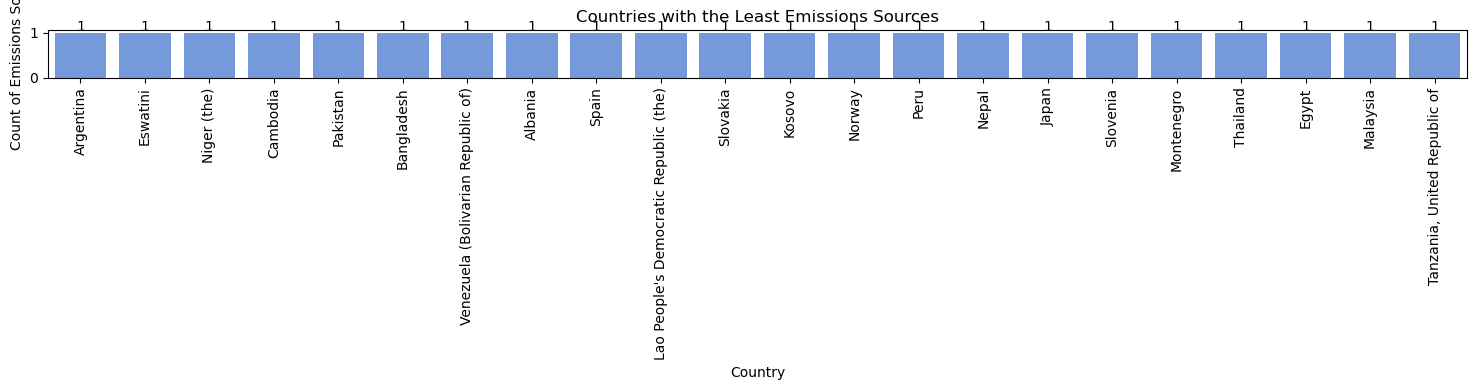

In [548]:
# for descriptive purposes only

plt.figure(figsize=(15, 4))
ax = sns.barplot(data=result_df, x='country_name', y='ct',color='cornflowerblue')

plt.title('Countries with the Least Emissions Sources')
plt.xlabel('Country')
plt.ylabel('Count of Emissions Sources')
plt.xticks(rotation=90)
plt.tight_layout()

for bar in ax.patches:
    height=bar.get_height()
    ax.annotate(format(height, '.0f'),
                     (bar.get_x() + bar.get_width() / 2., height),
                     ha = 'center', va = 'center',
                     xytext = (0, 4),
                     textcoords = 'offset points')

plt.savefig('../_figs/due20240829_country_emission_sources_least.pdf')
plt.savefig('../_figs/due20240829_country_emission_sources_least.png')

# Show the plot
plt.show()

#### Pie Chart of Emissions Sources

In [481]:
labels=emissions_sources['source_type'].value_counts().index
sizes=emissions_sources['source_type'].value_counts().values

In [482]:
labels_pct=[f'{label}, {size/sizes.sum()*100:.2f}%' for label,size in zip(labels,sizes)]
labels_pct

['Underground, 51.21%',
 'Surface, 46.38%',
 'Underground & Surface, 2.38%',
 'Refuse, 0.03%']

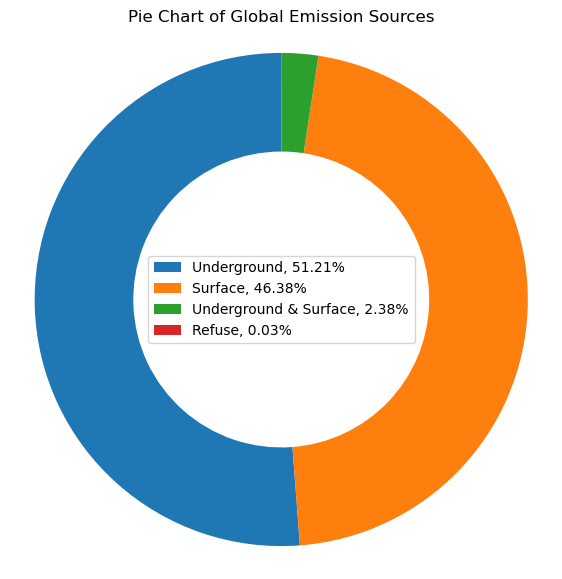

In [483]:
plt.figure(figsize=(7,7))

plt.pie(
    sizes,
    labels=None,  # Do not label slices directly
    autopct=None,
    startangle=90,
    wedgeprops=dict(width=0.4)
)

plt.legend(labels_pct, loc='center')#, bbox_to_anchor=(1.15, 1))

plt.title('Pie Chart of Global Emission Sources')

# ensure aspect ratio is equal meaning pie chart is a circle
plt.axis('equal')

# save figure
plt.savefig('../_figs/due20240829_emission_sources_pie.pdf')
plt.savefig('../_figs/due20240829_emission_sources_pie.png')

# show plot
plt.show()

#### Heatmap of Emission Sources

In [484]:
con=duckdb.connect(database=':memory:')
con.register('emissions_sources',emissions_sources)
world_emissions=con.execute('''
select
    iso3_country
    ,sum(emissions_quantity) as sum_emissions
from emissions_sources
where gas='ch4'
group by iso3_country;
''').fetchdf()
con.close()

world_emissions=pd.DataFrame(world_emissions)

world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

The data is very skewed towards China's output. Let's use an `sklearn` scaler to deal with this.

In [485]:
# Suppress specific UserWarnings
warnings.filterwarnings("ignore", message="n_quantiles.*is greater than the total number of samples.*")

from sklearn.preprocessing import QuantileTransformer

# using this scaler because it transforms the data 
# to follow a normal distribution

scaler=QuantileTransformer(output_distribution='normal')
world_emissions['scaled_emissions']=scaler.fit_transform(world_emissions[['sum_emissions']])

world_emissions

,iso3_country,sum_emissions,scaled_emissions
0,USA,2.459402e+07,2.172065
1,ARG,2.827994e+03,-1.343517
2,BIH,2.940165e+05,0.486143
3,IND,9.061939e+06,1.557284
4,MEX,2.847880e+05,0.444451
...,...,...,...
63,TUR,8.839673e+05,0.710149
64,BGD,7.706688e+04,-0.131320
65,CHN,2.560940e+08,5.199338
66,MNG,9.421957e+05,0.759153


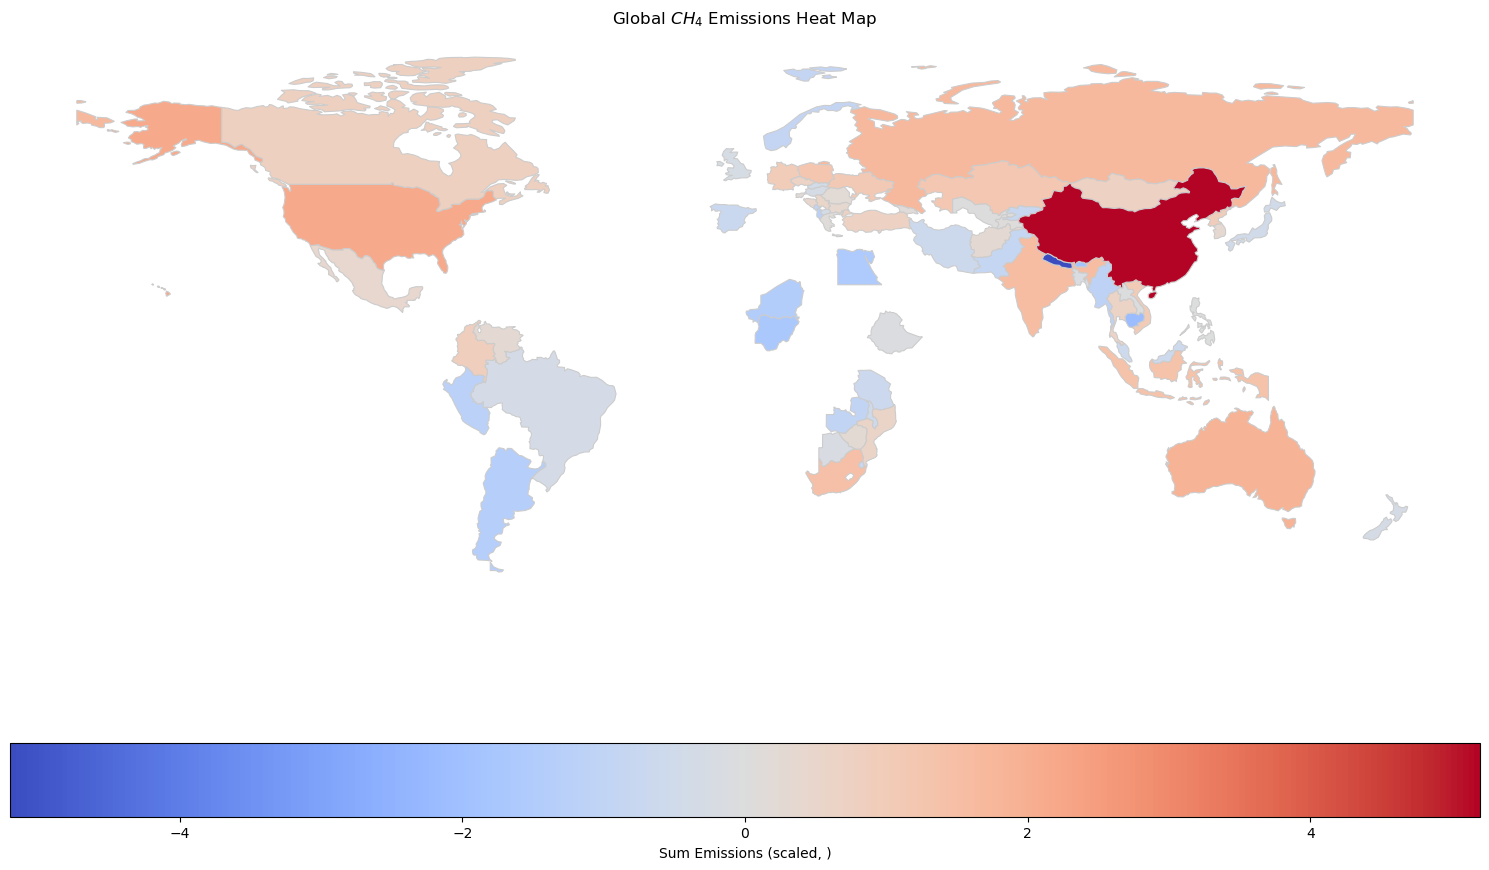

In [486]:
world_emissions_merged=world.merge(world_emissions,
                                   how='left',
                                   left_on='iso_a3',
                                   right_on='iso3_country')

world_emissions_merged['sum_emissions']=world_emissions_merged['sum_emissions'].fillna(0)

fig,ax=plt.subplots(1,1,figsize=(15,10))
world_emissions_merged.plot(
    column='scaled_emissions',
    cmap='coolwarm',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label':'Sum Emissions (scaled, )','orientation':'horizontal'}
)

plt.title('Global $CH_4$ Emissions Heat Map')
plt.axis('off')
plt.tight_layout()

# save figure
plt.savefig('../_figs/due20240829_global_ch4_emissions.pdf')
plt.savefig('../_figs/due20240829_global_ch4_emissions.png')

plt.show()

#### Correlation Tables

In [487]:
from scipy.stats import chi2_contingency

In [488]:
def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def cramers_v_matrix(df):
    """Compute a matrix of Cramér's V statistics for all pairs of categorical columns in a DataFrame."""
    cols = df.columns
    n = len(cols)
    cv_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cv_matrix[i, j] = cramers_v(df[cols[i]], df[cols[j]])
    return pd.DataFrame(cv_matrix, index=cols, columns=cols)

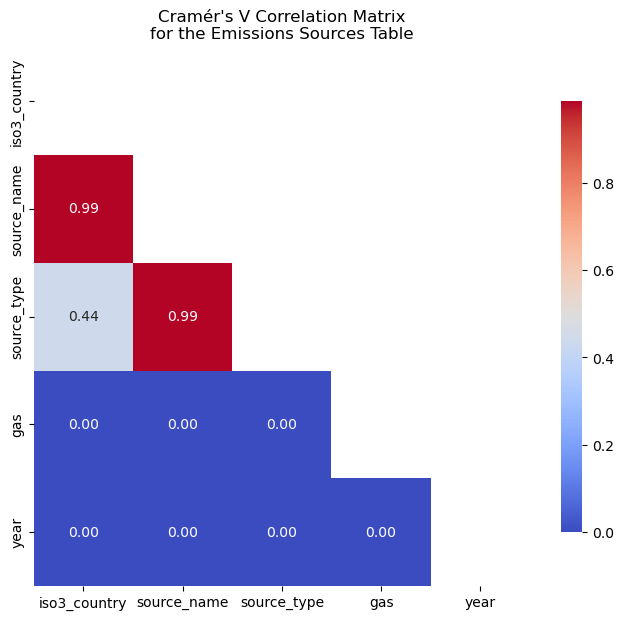

In [549]:
# Compute Cramér's V matrix
cv_matrix = cramers_v_matrix(emissions_sources[['iso3_country','source_name','source_type','gas','year']])

# generate mask for the upper triangle
mask = np.triu(np.ones_like(cv_matrix, dtype=bool))

# Plot the correlation matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cv_matrix, annot=True, cmap='coolwarm', #vmin=-1, vmax=1,
            mask=mask, cbar_kws={"shrink": .8},fmt='.2f')

plt.title("Cramér's V Correlation Matrix\nfor the Emissions Sources Table")

# save fig
plt.savefig('../_figs/due20240829_emissions_sources_categorical_correlation.pdf')
plt.savefig('../_figs/due20240829_emissions_sources_categorical_correlation.png')

plt.show()

In [490]:
columns_to_include = [col for col in emissions_sources.columns if col not in ('other8',
                                                                              'other3',
                                                                              'other4',
                                                                              'other7',
                                                                              'other9',
                                                                              'other10',
                                                                              'other8_def',
                                                                              'other9_def',
                                                                              'other10_def',
                                                                              'source_id')]

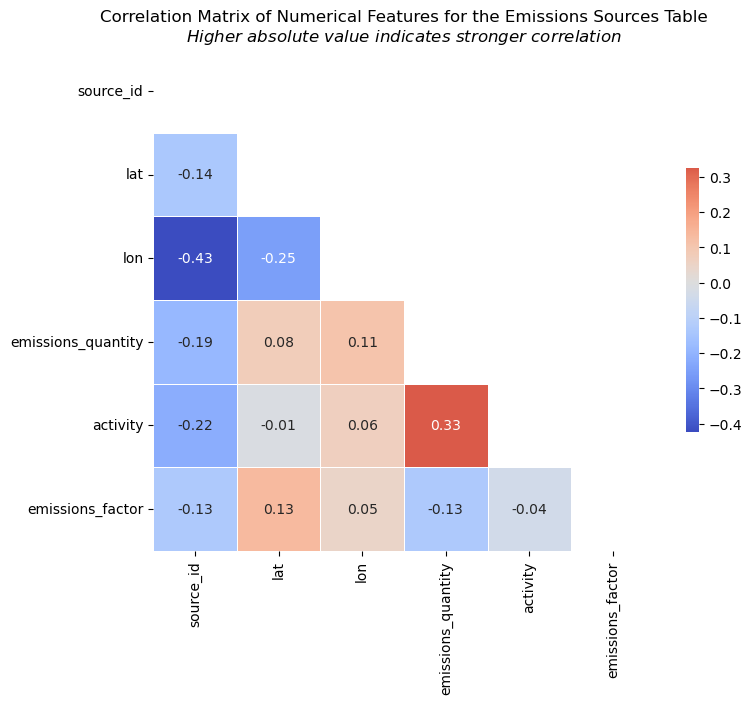

In [551]:
# compute correlation matrix
# corr=emissions_sources[columns_to_include].corr()
corr=emissions_sources[columns_to_include].corr(numeric_only=True)

# generate mask for the upper triangle
mask=np.triu(np.ones_like(corr, dtype=bool))

# set up matplotlib figure
f,ax = plt.subplots(figsize=(8,7))

# draw heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap='coolwarm',#vmax=1,vmin=-1,
            center=0,
            square=True,linewidths=.5,annot=True,
            fmt='.2f',cbar_kws={"shrink":.5})
plt.title('Correlation Matrix of Numerical Features for the Emissions Sources Table\n$Higher$ $absolute$ $value$ $indicates$ $stronger$ $correlation$')
plt.tight_layout()

# save fig
plt.savefig('../_figs/due20240829_emissions_sources_numerical_correlation.pdf')
plt.savefig('../_figs/due20240829_emissions_sources_numerical_correlation.png')

### `ownership` table

In [492]:
# import data
ownership=pd.read_csv('../_data/coal-mining_emissions_sources_ownership.csv')

In [493]:
ownership.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5492 entries, 0 to 5491
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   source_id                             5492 non-null   int64  
 1   source_name                           5492 non-null   object 
 2   iso3_country                          5492 non-null   object 
 3   sector                                5492 non-null   object 
 4   subsector                             5492 non-null   object 
 5   lat                                   5492 non-null   float64
 6   lon                                   5492 non-null   float64
 7   geometry_ref                          5492 non-null   object 
 8   relationship                          5492 non-null   object 
 9   ultimate_parent_name                  5492 non-null   object 
 10  ultimate_parent_id                    5492 non-null   int64  
 11  percent_interest_

In [494]:
ownership.sample(3)

,source_id,source_name,iso3_country,sector,subsector,lat,lon,geometry_ref,relationship,ultimate_parent_name,...,company_id,percent_interest_company,interest_units,start_date,end_date,created_date,modified_date,percent_company_datasource,percent_parent_datasource,ultimate_parent_revenue_annual (mil)
2732,16537,Weiqiang Coal Mine,CHN,fossil-fuel-operations,coal-mining,38.026939,109.285876,trace_109.285876_38.026939,owner,Shaanxi Hengshan Imp.and EXP,...,1.000000e+11,100.0,coal_reserves,1/1/22 0:00,12/31/22 0:00,49:34.0,NaN,{12647},"{6119,12647}",326
3182,16490,Yindonggou Coal Mine,CHN,fossil-fuel-operations,coal-mining,36.240220,106.615825,trace_106.615825_36.24022,owner,Ningxia State-owned Investment Management,...,1.000000e+11,100.0,coal_reserves,1/1/22 0:00,12/31/22 0:00,49:34.0,NaN,{12788},"{6119,12788}",756
3102,15766,Yangtai Tuncheng Coal Mine,CHN,fossil-fuel-operations,coal-mining,35.558124,112.534213,trace_112.534213_35.558124,owner,State-owned Assets Supervision and Administrat...,...,1.000000e+11,100.0,coal_reserves,1/1/22 0:00,12/31/22 0:00,49:33.9,NaN,{12766},"{6119,12766}",88


In [495]:
nUnique(ownership)

,column_name,n_unique_values
0,source_id,2987
1,source_name,2986
2,iso3_country,66
3,sector,1
4,subsector,1
5,lat,2916
6,lon,2917
7,geometry_ref,2925
8,relationship,1
9,ultimate_parent_name,1891


In [496]:
# add full country name like I did with the other tables
if 'country_name' not in ownership.columns:
    
    ownership=pd.merge(ownership,
                               iso3,
                               left_on='iso3_country',
                               right_on='alpha_3_code',
                               how='inner')
    
print('country_name' in ownership.columns)

True


There are some geographic data here. Let's plot them on a map!

#### Map of Ownership Sources

Let's join the emission sources to the ownership sources so that we can have a map with a color ramp of each source's emissions.

In [526]:
con=duckdb.connect(database=':memory:')
con.register('emissions_sources',emissions_sources)
con.register('ownership',ownership)
result=con.execute('''
select
    o.ultimate_parent_name
    ,o.source_id
    ,e.lat
    ,e.lon
    ,sum(e.emissions_quantity) as sum_emissions
from emissions_sources as e
join ownership as o on e.source_id=o.source_id
where gas='ch4'
group by o.source_id,o.ultimate_parent_name,e.lat,e.lon;
''').fetchdf()
result
con.close()

In [527]:
result

,ultimate_parent_name,source_id,lat,lon,sum_emissions
0,Nacco Industries,16421,47.469902,-101.074861,61261.987350
1,FM Coal,3164733,33.696389,-87.203056,2639.461334
2,Quinwood Coal,3164764,38.173611,-80.722222,0.000000
3,Quintana Capital Group,3164767,39.988611,-78.948056,9776.780249
4,Alpha Metallurgical Resources,3164768,37.891517,-81.301483,53229.136911
...,...,...,...,...,...
5484,Polska Grupa Górnicza,16173,50.045528,18.588419,458986.390533
5485,Bluenut Trading,16506,53.398991,91.095886,31871.046725
5486,Turkish Coal Enterprises,3164518,40.855953,34.758629,1543.255181
5487,Datong Shuangjian Industrial,16372,40.876386,35.621120,3231.993471


In [528]:
import geopandas as gpd
from shapely.geometry import Point
# import contextily as ctx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
import warnings
# ignore FutureWarnings
warnings.filterwarnings('ignore',category=FutureWarning)

In [529]:
world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

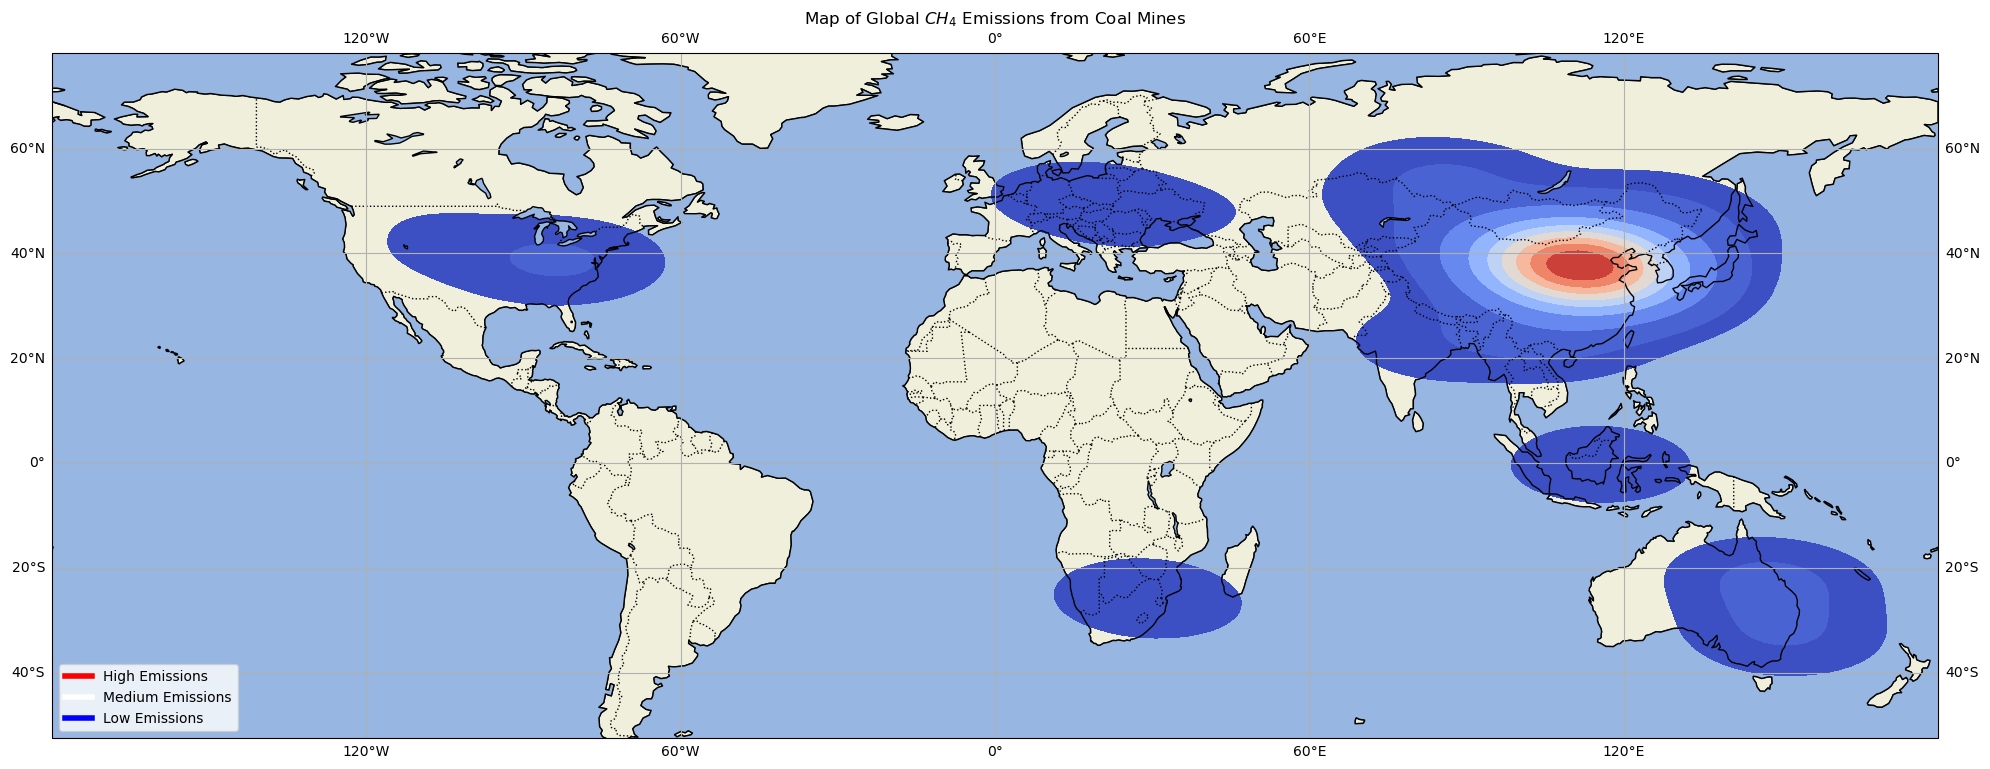

In [530]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(result, geometry=gpd.points_from_xy(result['lon'], result['lat']))

# Set coordinate reference system to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Create plot with Cartopy
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot density
sns.kdeplot(
    data=result,
    x='lon',
    y='lat',
    weights=result['sum_emissions'],
    cmap='coolwarm',
    fill=True,
    ax=ax
)

legend_elements = [
    Line2D([0], [0], color='red', lw=4, label='High Emissions'),
    Line2D([0], [0], color='white', lw=4, label='Medium Emissions'),
    Line2D([0], [0], color='blue', lw=4, label='Low Emissions')
]

# Add a legend with custom labels
ax.legend(handles=legend_elements, loc='lower left')

# Add basemap features
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, edgecolor='black')

# Optionally add gridlines
ax.gridlines(draw_labels=True)

# Set extent if needed (min_lon, max_lon, min_lat, max_lat)
ax.set_extent([result['lon'].min(), result['lon'].max(), result['lat'].min(), result['lat'].max()])

plt.title('Map of Global $CH_4$ Emissions from Coal Mines')
plt.tight_layout()

# Save plot
plt.savefig('../_figs/due20240829_density_map.pdf')
plt.savefig('../_figs/due20240829_density_map.png')

plt.show()

#### Correlation Tables

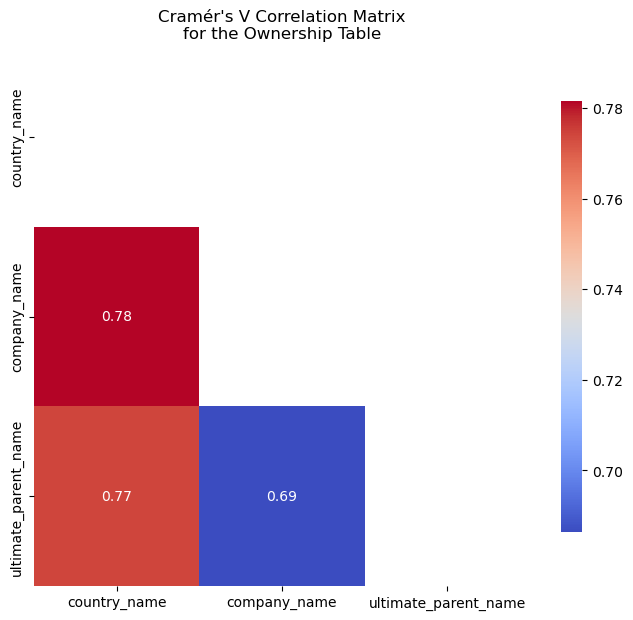

In [555]:
# Compute Cramér's V matrix
cv_matrix = cramers_v_matrix(ownership[['country_name','company_name','ultimate_parent_name']])

# generate mask for the upper triangle
mask = np.triu(np.ones_like(cv_matrix, dtype=bool))

# Plot the correlation matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cv_matrix, annot=True, cmap='coolwarm', #vmin=-1, vmax=1,
            mask=mask, cbar_kws={"shrink": .8},fmt='.2f')

plt.title("Cramér's V Correlation Matrix\nfor the Ownership Table")

# save fig
plt.savefig('../_figs/due20240829_ownership_categorical_correlation.pdf')
plt.savefig('../_figs/due20240829_ownership_categorical_correlation.png')

plt.show()

In [552]:
columns_to_include = [col for col in emissions_sources.columns if col not in ('other3','other4','other7','other8', 'other8_def', 'other9', 'other9_def', 'other10', 'other10_def','source_id')]

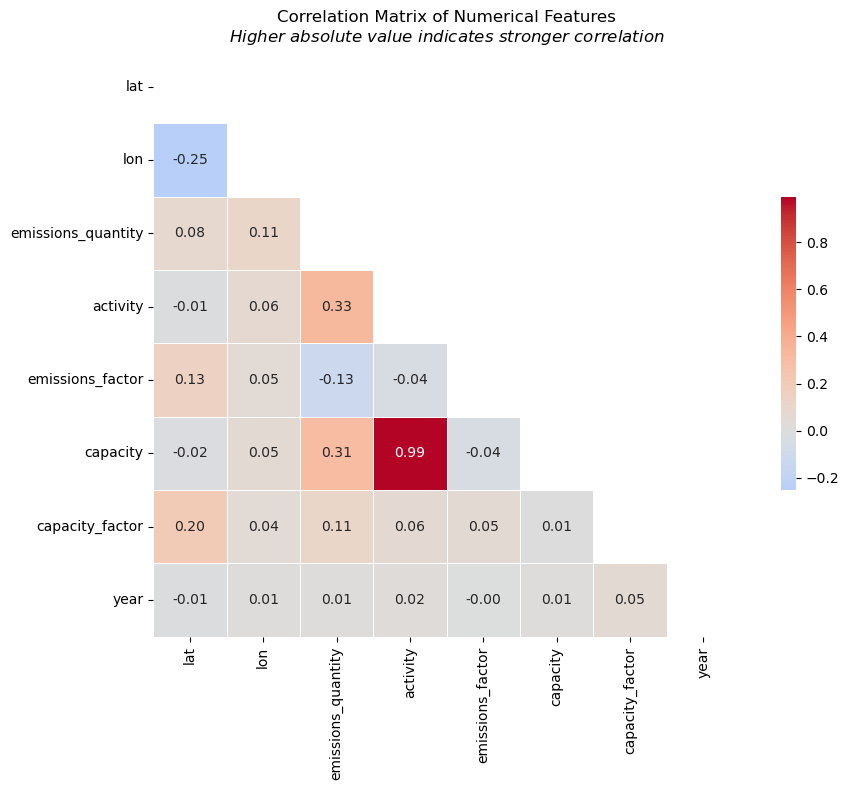

In [554]:
# compute correlation matrix
corr=emissions_sources[columns_to_include].corr()

# generate mask for the upper triangle
mask=np.triu(np.ones_like(corr, dtype=bool))

# set up matplotlib figure
f,ax = plt.subplots(figsize=(10,8))

# draw heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap='coolwarm',#vmax=1,vmin=-1,
            center=0,
            square=True,linewidths=.5,annot=True,
            fmt='.2f',cbar_kws={"shrink":.5})
plt.title('Correlation Matrix of Numerical Features\n$Higher$ $absolute$ $value$ $indicates$ $stronger$ $correlation$')
plt.tight_layout()

# save fig
plt.savefig('../_figs/due20240829_ownership_numerical_correlation.pdf')
plt.savefig('../_figs/due20240829_ownership_numerical_correlation.png')

### Additional Data: Mineral Extraction

I'm curious if other data sources, like mineral extraction. How does it correlate with coal extraction? What companies, if any, are found in both of these sectors? We'll use the mineral extraction data source from the [Climate TRACE](#https://climatetrace.org/data) website.

In [505]:
# import data

# iron is most likely found in association with coal mining
fe_country_emissions=pd.read_csv('../_data/mineral_extraction/DATA/iron-mining_country_emissions.csv')
fe_ownership=pd.read_csv('../_data/mineral_extraction/DATA/iron-mining_emissions_sources_ownership.csv')
fe_sources=pd.read_csv('../_data/mineral_extraction/DATA/iron-mining_emissions_sources.csv')

# bx_country_emissions=pd.read_csv('../_data/mineral_extraction/DATA/bauxite-mining_country_emissions.csv')
# bx_ownership=pd.read_csv('../_data/mineral_extraction/DATA/bauxite-mining_emissions_sources_ownership.csv')
# bx_sources=pd.read_csv('../_data/mineral_extraction/DATA/bauxite-mining_emissions_sources.csv')

# cu_country_emissions=pd.read_csv('../_data/mineral_extraction/DATA/copper-mining_country_emissions.csv')
# cu_ownership=pd.read_csv('../_data/mineral_extraction/DATA/copper-mining_emissions_sources_ownership.csv')
# cu_sources=pd.read_csv('../_data/mineral_extraction/DATA/copper-mining_emissions_sources.csv')

Add country_names to all the dataframes:

In [506]:
def addCountry(df, iso3):
    '''Adds country name if not added already'''
    if 'country_name' not in df.columns:
        # Perform merge and handle missing country names
        df = pd.merge(df,
                      iso3,
                      left_on='iso3_country',
                      right_on='alpha_3_code',
                      how='left')  # Use 'left' to keep all rows in df
    return df

In [507]:
# list of DataFrames
dataframes = [fe_country_emissions, fe_ownership, fe_sources]

# apply the function to each DataFrame
updated_dataframes = [addCountry(df, iso3) for df in dataframes]

# reassign them to original variables
fe_country_emissions, fe_ownership, fe_sources = updated_dataframes[0], updated_dataframes[1], updated_dataframes[2]

print('done adding country_names!')

done adding country_names!


In [508]:
fe_country_emissions['start_time']=pd.to_datetime(fe_country_emissions['start_time'])
fe_ownership['start_date']=pd.to_datetime(fe_ownership['start_date'])
fe_sources['start_time']=pd.to_datetime(fe_sources['start_time'])

# check to see if it changed
# country_emissions.info()
# yes

In [509]:
# create a column for just the year
fe_country_emissions['year']=fe_country_emissions['start_time'].dt.year
fe_ownership['year']=fe_ownership['start_date'].dt.year
fe_sources['year']=fe_sources['start_time']

fe_country_emissions['year'].value_counts()
# fe_ownership['year'].value_counts()
# fe_sources['year'].value_counts()

2015    1255
2016    1255
2017    1255
2018    1255
2019    1255
2020    1255
2021    1255
2022    1255
Name: year, dtype: int64

#### Barplot of Emissions Per Year

In [510]:
con = duckdb.connect()
con.register('fe_ownership',fe_ownership)
con.register('fe_sources',fe_sources)
con.register('fe_country_emissions',fe_country_emissions)

query='''
select
    year
    ,gas
    ,sum(emissions_quantity) as sum_emissions
from fe_country_emissions
group by year,gas
having sum_emissions is not null;
'''

results=con.execute(query).fetchdf()
results
# master_df.to_csv('../_data/mineral_extraction/DATA/master_table.csv',index=False)

,year,gas,sum_emissions
0,2016,co2,97909661.0
1,2017,co2e_20yr,99674713.0
2,2022,co2,73093600.0
3,2015,co2e_20yr,95808899.0
4,2018,co2e_100yr,99693200.0
5,2018,co2,99693200.0
6,2019,co2e_20yr,103822733.0
7,2020,co2e_20yr,87597772.0
8,2021,co2e_20yr,69309938.0
9,2015,co2,95808899.0


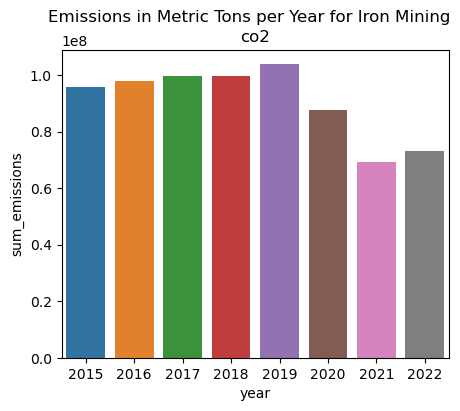

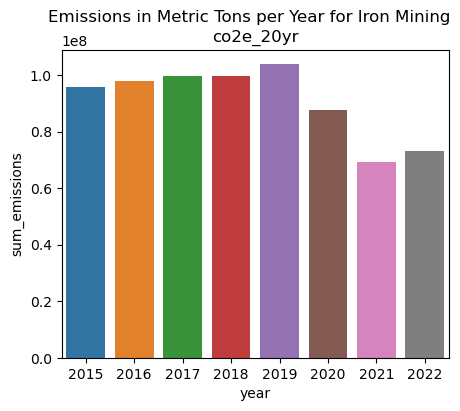

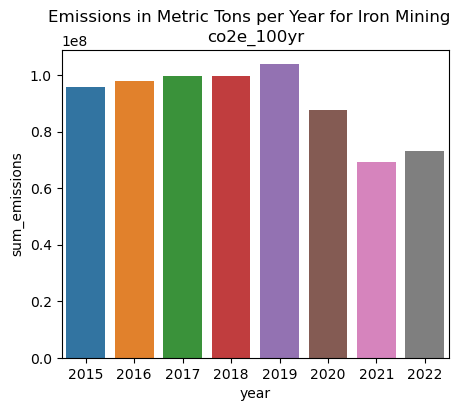

In [511]:
gases=list(results['gas'].unique())
titles=gases # titles is using gases too
file_names=['due20240829_iron_'+item for item in gases]

for gas,title,file_name in zip(gases,titles,file_names):
    plt.figure(figsize=(5,4))
    sns.barplot(data=results[results['gas']==gas],
                x='year',
                y='sum_emissions')
    plt.title(title)
    plt.suptitle('Emissions in Metric Tons per Year for Iron Mining')
    
    plt.savefig(f'../_figs/{file_name}.pdf')
    plt.savefig(f'../_figs/{file_name}.png')
                
    plt.show()

#### Barplot of Countries' $CO_2$ Emissions Due to Iron Mining

In [512]:
con=duckdb.connect(database=':memory:')
con.register('fe_country_emissions',fe_country_emissions)
country_sum=con.execute('''
with sumemissions as (
select 
    distinct country_name
    ,sum(emissions_quantity) as sum_emissions
    ,gas
from fe_country_emissions
where gas='co2'
group by country_name,gas
),
ranked as (
select 
    country_name
    ,gas
    ,sum_emissions
    ,rank() over (order by sum_emissions desc) as rnk
from sumemissions
)
select
    country_name
    ,gas
    ,sum_emissions
from ranked
where rnk<=10;
''').fetchdf()
con.close()
country_sum

,country_name,gas,sum_emissions
0,India,co2,188047709.0
1,China,co2,168749415.0
2,Brazil,co2,96112463.0
3,Russian Federation (the),co2,49897593.0
4,Australia,co2,39867962.0
5,United States of America (the),co2,37302831.0
6,Iran (Islamic Republic of),co2,26727895.0
7,Canada,co2,24007430.0
8,Ukraine,co2,18908490.0
9,Kazakhstan,co2,14251674.0


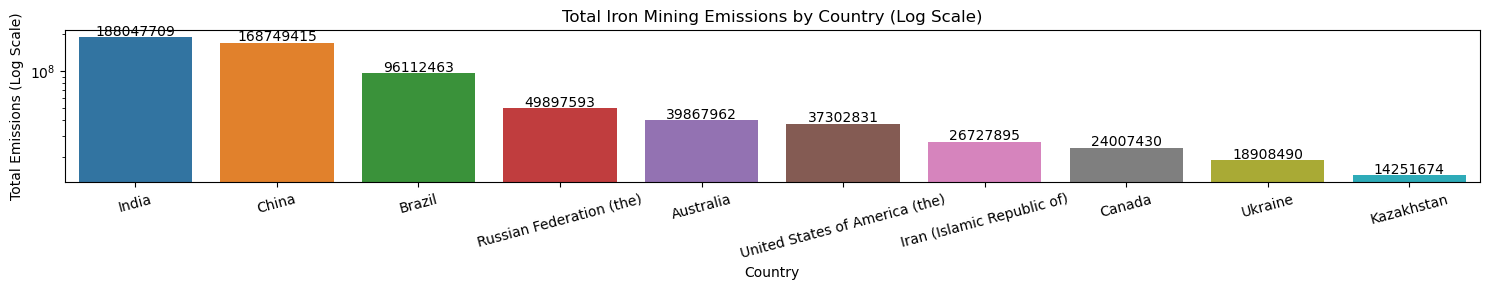

In [556]:
plt.figure(figsize=(15, 3))
ax = sns.barplot(data=country_sum, x='country_name', y='sum_emissions')

plt.title('Total Iron Mining Emissions by Country (Log Scale)')
plt.xlabel('Country')
plt.ylabel('Total Emissions (Log Scale)')
plt.xticks(rotation=15)
plt.yscale('log')
plt.tight_layout()

for bar in ax.patches:
    height=bar.get_height()
    ax.annotate(format(height, '.0f'),
                     (bar.get_x() + bar.get_width() / 2., height),
                     ha = 'center', va = 'center',
                     xytext = (0, 4),
                     textcoords = 'offset points')
    
plt.savefig('../_figs/due20240829_total_country_emission_sources_log_iron.pdf')
plt.savefig('../_figs/due20240829_total_country_emission_sources_log_iron.png')

# Show the plot
plt.show()

#### Heatmap of Iron Mining Emission Sources

In [514]:
con=duckdb.connect(database=':memory:')
con.register('fe_sources',fe_sources)
world_emissions=con.execute('''
with cte as (
select
    iso3_country
    ,sum(emissions_quantity) as sum_emissions
from fe_sources
where gas='co2'
group by iso3_country
)
select *
from cte
where sum_emissions!=0 and sum_emissions is not null
order by sum_emissions desc;
''').fetchdf()
con.close()

world_emissions=pd.DataFrame(world_emissions)

world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [515]:
world_emissions

,iso3_country,sum_emissions
0,BRA,39671663.0
1,IND,39006882.0
2,RUS,28155950.0
3,USA,24787251.0
4,CHN,21304480.0
5,AUS,16654942.0
6,CAN,15164401.0
7,IRN,10467749.0
8,KAZ,4784894.0
9,ZAF,4398811.0


In [516]:
# Suppress specific UserWarnings
warnings.filterwarnings("ignore", message="n_quantiles.*is greater than the total number of samples.*")

from sklearn.preprocessing import QuantileTransformer

# using this scaler because it transforms the data 
# to follow a normal distribution

scaler=QuantileTransformer(output_distribution='normal')
world_emissions['scaled_emissions']=scaler.fit_transform(world_emissions[['sum_emissions']])

world_emissions

,iso3_country,sum_emissions,scaled_emissions
0,BRA,39671663.0,5.199338
1,IND,39006882.0,1.711675
2,RUS,28155950.0,1.359737
3,USA,24787251.0,1.124338
4,CHN,21304480.0,0.938814
5,AUS,16654942.0,0.781034
6,CAN,15164401.0,0.640667
7,IRN,10467749.0,0.511936
8,KAZ,4784894.0,0.391196
9,ZAF,4398811.0,0.275921


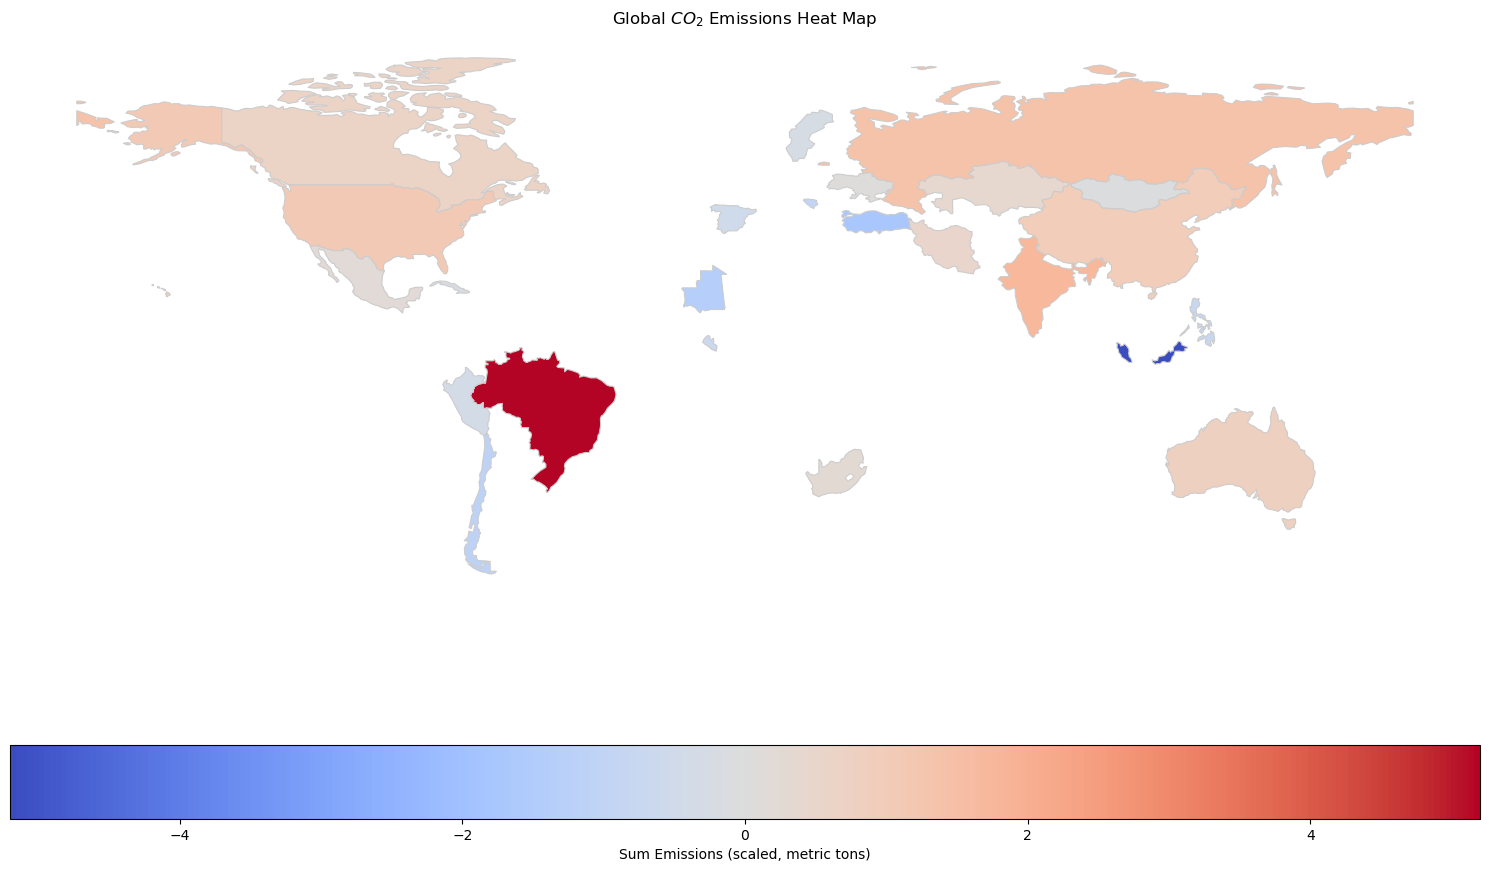

In [517]:
world_emissions_merged=world.merge(world_emissions,
                                   how='left',
                                   left_on='iso_a3',
                                   right_on='iso3_country')

world_emissions_merged['sum_emissions']=world_emissions_merged['sum_emissions'].fillna(0)

fig,ax=plt.subplots(1,1,figsize=(15,10))
world_emissions_merged.plot(
    column='scaled_emissions',
    cmap='coolwarm',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label':'Sum Emissions (scaled, metric tons)','orientation':'horizontal'}
)

plt.title('Global $CO_2$ Emissions Heat Map')
plt.axis('off')
plt.tight_layout()

# save figure
plt.savefig('../_figs/due20240829_global_co2_emissions_iron.pdf')
plt.savefig('../_figs/due20240829_global_co2_emissions_iron.png')

plt.show()

#### Map of Ownership Sources

In [558]:
con=duckdb.connect(database=':memory:')
con.register('fe_sources',fe_sources)
con.register('fe_ownership',fe_ownership)
result=con.execute('''
select
    o.ultimate_parent_name
    ,o.source_id
    ,e.lat
    ,e.lon
    ,o.country_name
    ,sum(e.emissions_quantity) as sum_emissions
from fe_sources as e
join fe_ownership as o on e.source_id=o.source_id
where gas='co2'
group by o.source_id,o.ultimate_parent_name,e.lat,e.lon,o.country_name
having sum_emissions is not null and sum_emissions != 0
order by sum_emissions desc;
''').fetchdf()
con.close()
result

,ultimate_parent_name,source_id,lat,lon,country_name,sum_emissions
0,Anglo American,25487114,-18.893736,-43.419546,Brazil,9543429.0
1,United States Steel,25487498,47.544885,-92.631421,United States of America (the),9458269.0
2,ArcelorMittal,25487152,52.756210,-67.316612,Canada,8218250.0
3,EVRAZ,25487415,58.752653,59.514403,Russian Federation (the),7655744.0
4,Vale,25487131,-6.058158,-50.167762,Brazil,7236647.0
...,...,...,...,...,...,...
138,Sinosteel,25486988,-29.149215,116.820824,Australia,4280.0
139,GWR Group,25487060,-26.793453,119.957057,Australia,3974.0
140,Strike Resources,25487394,-13.707750,-73.344315,Peru,1780.0
141,ArcelorMittal,25487516,-24.610118,27.387873,South Africa,939.0


In [559]:
world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

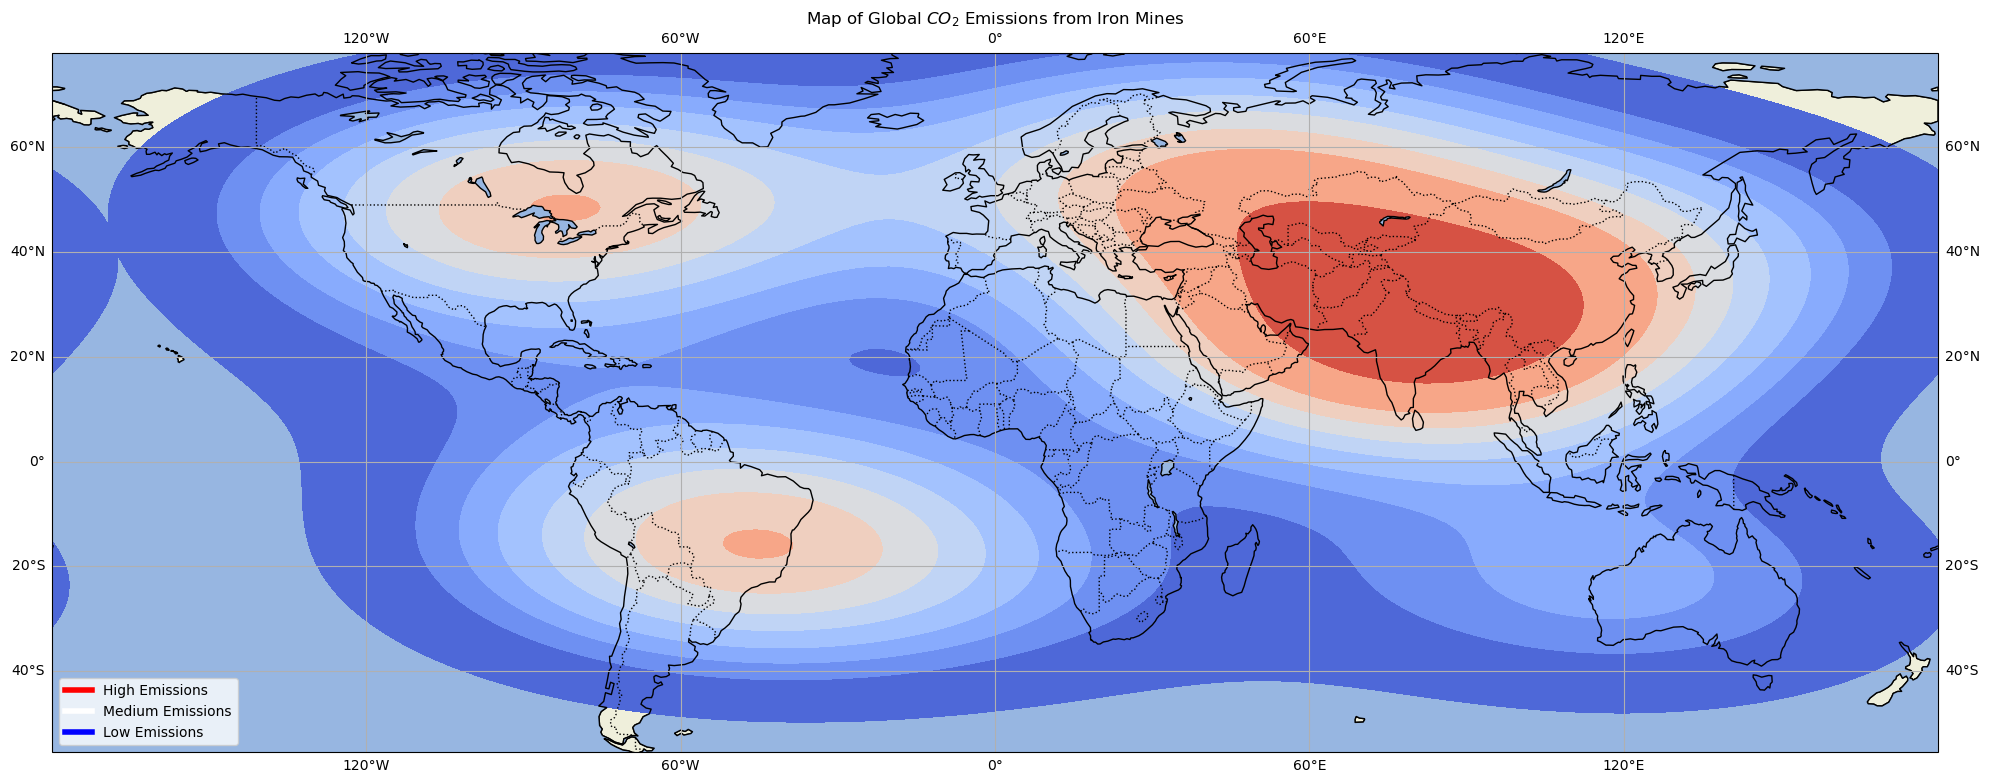

In [568]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(result, geometry=gpd.points_from_xy(result['lon'], result['lat']))

# Set coordinate reference system to WGS84
gdf.set_crs(epsg=4326, inplace=True)

# Create plot with Cartopy
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot density
sns.kdeplot(
    data=result,
    x='lon',
    y='lat',
    weights=result['sum_emissions'],
    cmap='coolwarm',
    fill=True,
    ax=ax
)

legend_elements = [
    Line2D([0], [0], color='red', lw=4, label='High Emissions'),
    Line2D([0], [0], color='white', lw=4, label='Medium Emissions'),
    Line2D([0], [0], color='blue', lw=4, label='Low Emissions')
]

# Add a legend with custom labels
ax.legend(handles=legend_elements, loc='lower left')

# Add basemap features
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, edgecolor='black')

# Optionally add gridlines
ax.gridlines(draw_labels=True)

# Set extent if needed (min_lon, max_lon, min_lat, max_lat)
ax.set_extent([result['lon'].min(), result['lon'].max(), result['lat'].min(), result['lat'].max()])

plt.title('Map of Global $CO_2$ Emissions from Iron Mines')
plt.tight_layout()

# Save plot
plt.savefig('../_figs/due20240829_density_map_iron.pdf')
plt.savefig('../_figs/due20240829_density_map_iron.png')

plt.show()

#### Correlation Tables

In [542]:
columns_to_include = [col for col in emissions_sources.columns if col in ('source_id', 'lat', 'lon', 'emissions_quantity', 'activity', 'emissions_factor')]

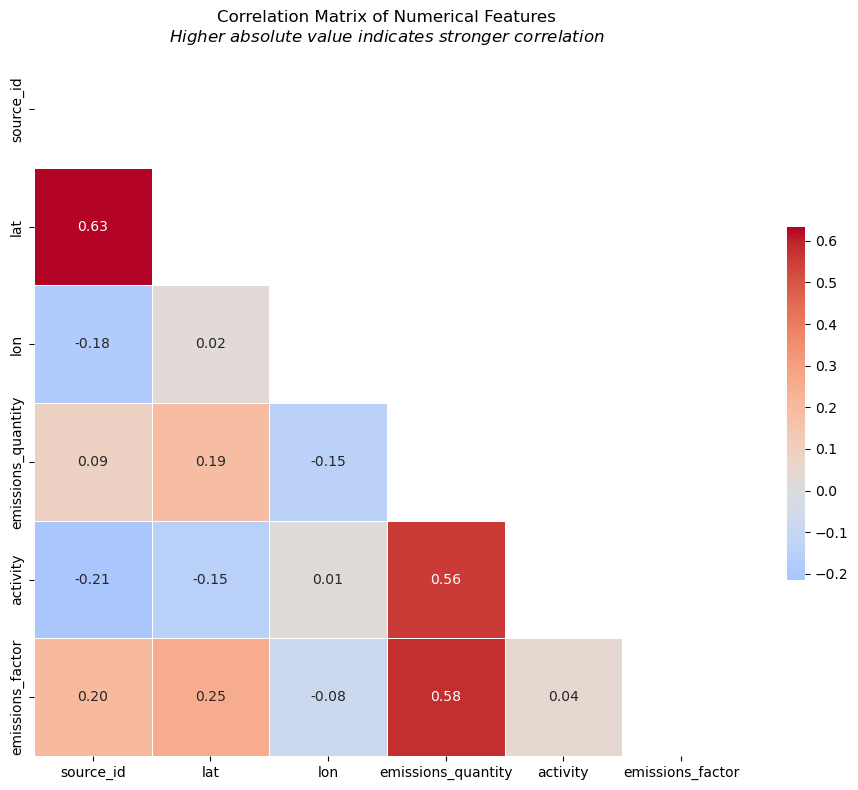

In [544]:
# compute correlation matrix
corr=fe_sources[columns_to_include].corr()

# generate mask for the upper triangle
mask=np.triu(np.ones_like(corr, dtype=bool))

# set up matplotlib figure
f,ax = plt.subplots(figsize=(10,8))

# draw heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap='coolwarm',#vmax=1,vmin=-1,
            center=0,
            square=True,linewidths=.5,annot=True,
            fmt='.2f',cbar_kws={"shrink":.5})
plt.title('Correlation Matrix of Numerical Features\n$Higher$ $absolute$ $value$ $indicates$ $stronger$ $correlation$')
plt.tight_layout()

# save fig
plt.savefig('../_figs/due20240829_ownership_numerical_correlation_iron.pdf')
plt.savefig('../_figs/due20240829_ownership_numerical_correlation_iron.pdf')